# Titanic survival prediction model

Honestly, this is the most notorious project in the world of data science. Anyway I think this is a nice project to start with because it really friendly.
I'll create a model to predict whether or not someone will survive the Titanic disaster
**Not done yet!**

In [181]:
url = "https://faithmag.com/sites/default/files/styles/original/public/2018-09/titanic2.jpg"
from IPython.display import HTML
html1 = f'<img src={url} width="750" height="900" align="center"/>'
HTML(html1)

## Table Of Contents:
* [1. Obtain data](#1)
* [2. Data cleaning](#2)
* [3. Data exploration](#3)
* [4. Modeling](#4)

## Obtain the data
The dataset are given by Kaggle and you can download it from
kaggle directly - https://www.kaggle.com/c/titanic

In [182]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
sns.set(palette="colorblind",style="whitegrid")
%matplotlib inline






In [183]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Dictionary
+ Survived: 0 = No, 1 = Yes
+ Pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
+ Sibsp: # of siblings / spouses aboard the Titanic
+ Parch: # of parents / children aboard the Titanic
+ Ticket: Ticket number
+ Cabin: Cabin number
+ Embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

## 2. Data cleaning <a class="anchor" id="2"></a>

**First, let's clean our data.**

In [184]:
print(train_data.info())
print("-"*40)
print(test_data.info())
print("-"*40)
#Checking for duplicates
print(len(train_data['PassengerId'].unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pass

### Take care of missing values:


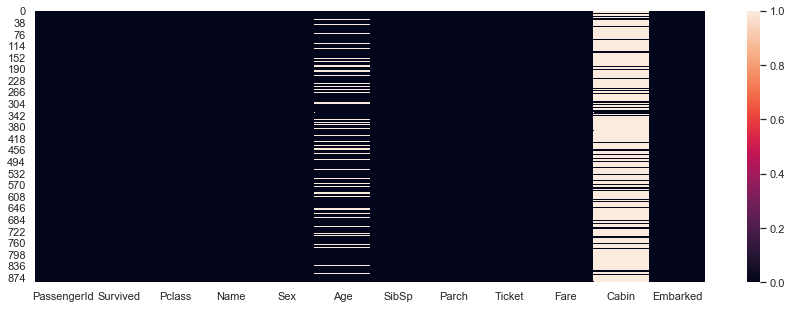

In [185]:
fig = plt.figure(figsize=(15,5))
sns.heatmap(train_data.isnull())

We can see that the cabin column is pretty full with nulls, so i will drop him from the dataset.
I can assume that the ticket number is also pretty arbitrary and we can drop it too.

In [186]:
train_data.drop(["Cabin", "Ticket"], axis=1, inplace=True)
test_data.drop(["Cabin", "Ticket"], axis=1, inplace=True)

In [187]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

So right now we have 177 missing values in the Age column and 2 missing values in the Embarked column.
I will fill the missing values in the Age column with the mean value of each Sex to make it accurate as i can.
* The age missing values can be filled also by the corelation between other variables like Pclass and age sa well.
* In matter of fact, I can build a whole new model just to fill the age values.

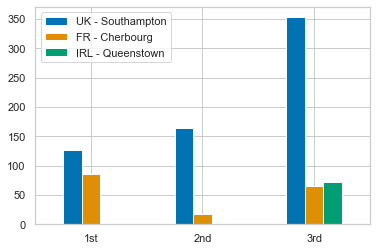

In [188]:
train_data["Age"].fillna(train_data.groupby("Sex")["Age"].transform("median"), inplace=True)
test_data["Age"].fillna(test_data.groupby("Sex")["Age"].transform("median"), inplace=True)


pclass1 = train_data[train_data["Pclass"] == 1]["Embarked"].value_counts()
pclass2 = train_data[train_data["Pclass"] == 2]["Embarked"].value_counts()
pclass3 = train_data[train_data["Pclass"] == 3]["Embarked"].value_counts()

pclass_df = pd.DataFrame([pclass1, pclass2, pclass3], index=["1st", "2nd", "3rd"])
x = pclass_df.plot(kind="bar")
x.legend(("UK - Southampton","FR - Cherbourg","IRL - Queenstown"))
x.tick_params(labelrotation=0)
## last place here - need to treat the embarked!

more than 50% of 1st class are from S embark
more than 50% of 2nd class are from S embark
more than 50% of 3rd class are from S embark

**fill out missing embark with S embark**

In [189]:
train_data.Embarked.fillna("S", inplace=True)


## 3. Data exploration: <a class="anchor" id="3"></a>
We good to go! no null values.
Lets explore some intersting connection inside our data.
Let's see how each feature effect the survival rate.

In [190]:
def bar_maker(feature, ax):
    survived = train_data[train_data['Survived']==1][feature].value_counts()
    dead = train_data[train_data['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(30,15), ax=ax, title=feature, fontsize=20)
    ax.tick_params(labelrotation=0)
    ax.legend(fontsize=19)
    ax.set_title(feature,fontweight="bold", size=20)

#Some mapping to help our algorithms to understand the data with dummy values
sex_mapping = {"male":0, "female":1}
train_data.Sex = train_data["Sex"].map(sex_mapping)
test_data.Sex = test_data["Sex"].map(sex_mapping)

embarked_mapping = {"S":0, "C":1,"Q":2}
train_data.Embarked = train_data["Embarked"].map(embarked_mapping)
test_data.Embarked = test_data["Embarked"].map(embarked_mapping)

train_data.loc[train_data.Fare <=8, "Fare_group"] = 1
train_data.loc[(train_data.Fare <=15)&(train_data.Fare>8), "Fare_group"] = 2
train_data.loc[(train_data.Fare <=32)&(train_data.Fare>15), "Fare_group"] = 3
train_data.loc[(train_data.Fare>=32), "Fare_group"] = 4

test_data.loc[test_data.Fare <=8, "Fare_group"] = 1
test_data.loc[(test_data.Fare <=15)&(test_data.Fare>8), "Fare_group"] = 2
test_data.loc[(test_data.Fare <=32)&(test_data.Fare>15), "Fare_group"] = 3
test_data.loc[(test_data.Fare>=32), "Fare_group"] = 4


I will make an correlation heatmap which will help me understand the strongest correlations between the variables. 

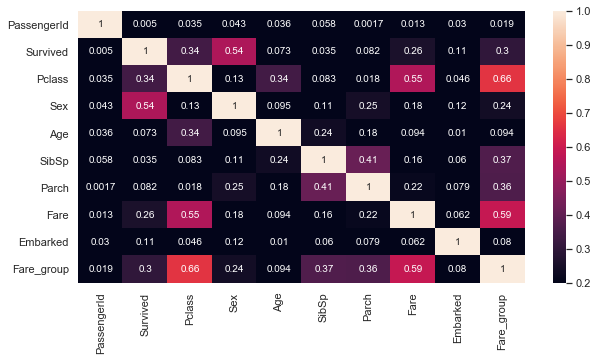

In [191]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(np.abs(train_data.corr()),annot=True,ax=ax,vmin=0.20)

In [192]:
np.abs(train_data.corr())
np.abs(train_data.corr()).loc["Survived"].sort_values(ascending=False)

Survived       1.000000
Sex            0.543351
Pclass         0.338481
Fare_group     0.302593
Fare           0.257307
Embarked       0.106811
Parch          0.081629
Age            0.073296
SibSp          0.035322
PassengerId    0.005007
Name: Survived, dtype: float64

As we can see, the top 4 correlations to our unindependent value are : Sex, Pclass, Fare and Embarked.
Let's explore those features.

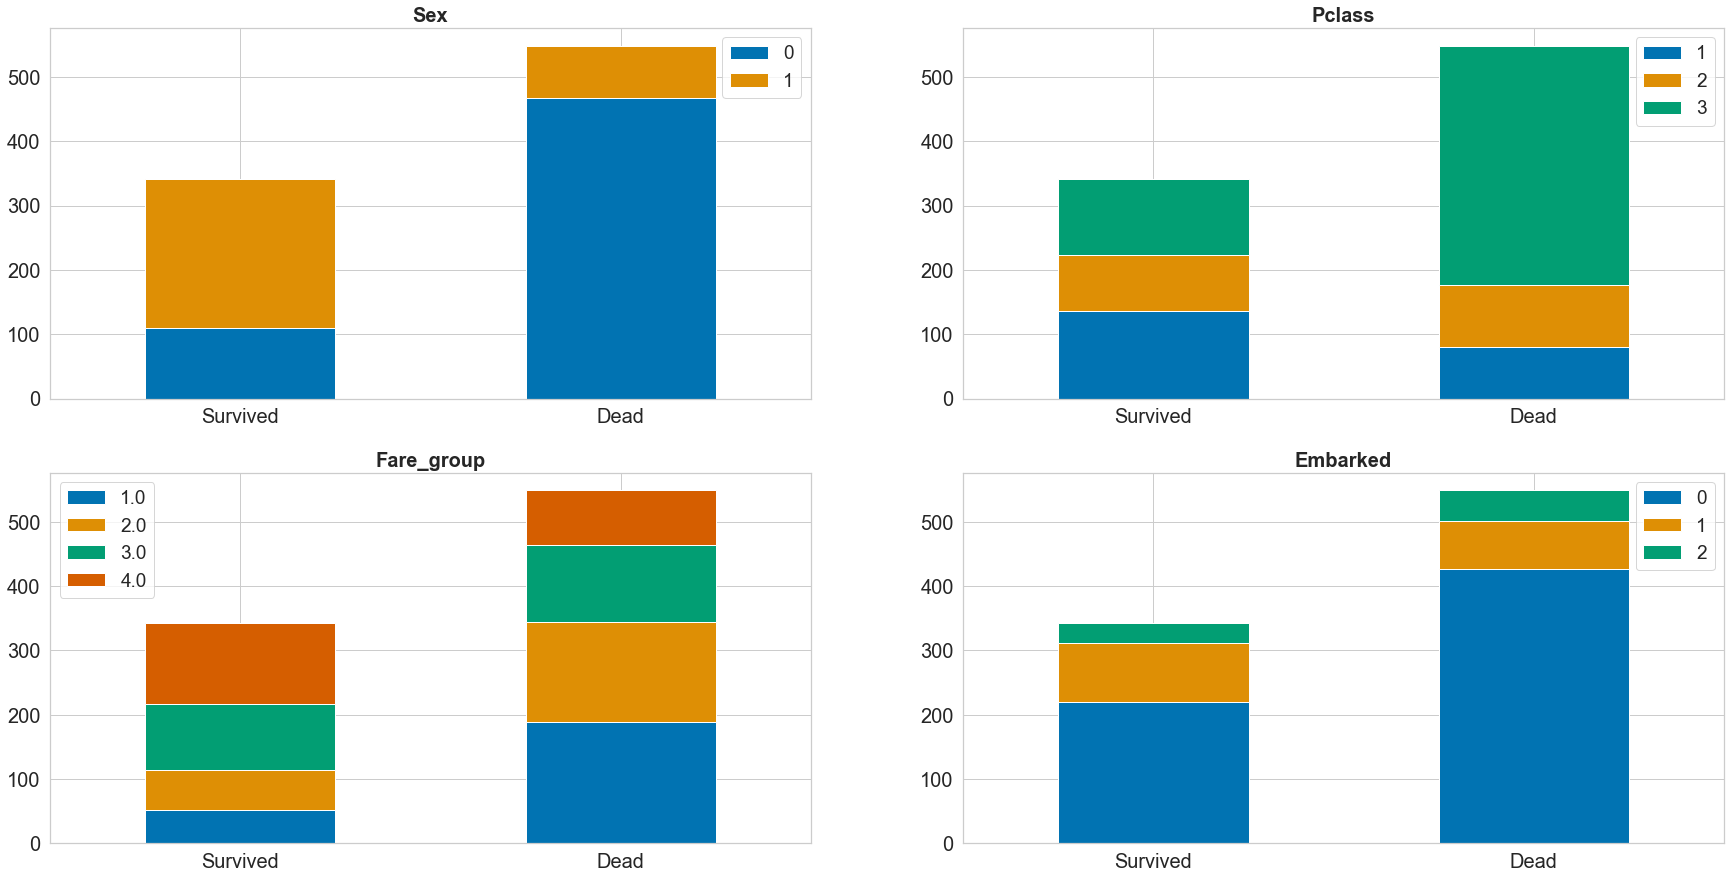

In [193]:
features = ["Sex", "Pclass", "Fare_group", "Embarked"]
index_plot = [[i,j] for i in [0,1] for j in [0,1]]

fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(25,15))
fig.set_figheight(30)
bar_maker(features[0], axs[0,0])
bar_maker(features[1], axs[0,1])
bar_maker(features[2], axs[1,0])
bar_maker(features[3], axs[1,1])



### Some conclusions:

#### Sex
*    This feature have the greatest impact of all.
     Men survival rate is 18.8%, While woman survival rate is 74.2%
     
#### Pclass
*   Correlation between your Pclass to the number of Deads.
    Pclass 3 is more likley to die

#### Parch
*    We can see that the more expensive the ticket, the survival rate is higher (probably with some correlation to the Pclass feature)

#### Embarked
*    Most of the deads got to the ship from Southhampton and Queenstownn - but i can assume that it's about the people's age
     or their Pclass.
     
     Let's check it out.
     



In [194]:
#Making age groups
train_data.loc[(train_data.Age <=3), "Age_group"] = "Babies"
train_data.loc[(train_data.Age <=10)&(train_data.Age>3), "Age_group"] = "Childrens"
train_data.loc[(train_data.Age <=17)&(train_data.Age>10), "Age_group"] = "Teenagers"
train_data.loc[(train_data.Age <=55)&(train_data.Age>17), "Age_group"] = "Grown-Ups"
train_data.loc[(train_data.Age>=55), "Age_group"] = "Old-People"

## 3.1 Sex


# fill

Text(0.5, 1.0, 'Men')

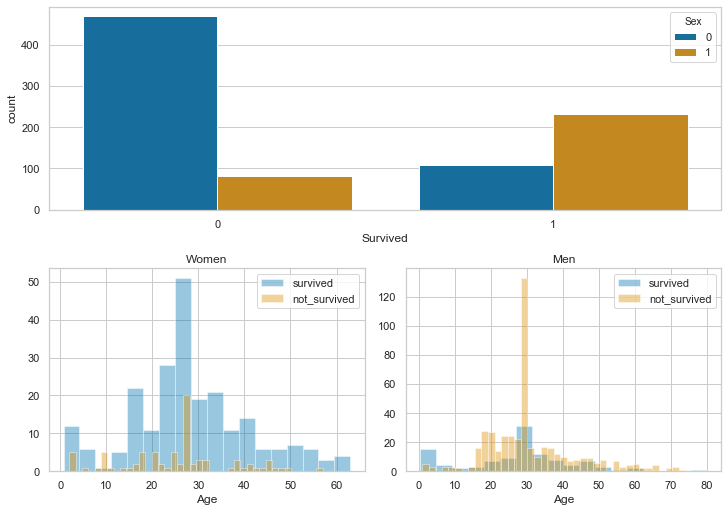

In [195]:
fig = plt.figure(constrained_layout=True,figsize=(10,7))
gs = fig.add_gridspec(2, 2)

women_survived = train_data[(train_data.Sex == 1)&(train_data.Survived == 1)]
women_died = train_data[(train_data.Sex == 1)&(train_data.Survived == 0)]
men_survived = train_data[(train_data.Sex == 0)&(train_data.Survived == 1)]
men_died = train_data[(train_data.Sex == 0)&(train_data.Survived == 0)]

f_ax1 = fig.add_subplot(gs[0, :])
sns.countplot(x="Survived", hue="Sex",data= train_data,ax=f_ax1)

f_ax2 = fig.add_subplot(gs[1, :1])
sns.distplot(women_survived.Age,bins=18, label = "survived", kde =False,ax=f_ax2)
sns.distplot(women_died.Age.dropna(), bins=40, label = "not_survived", ax=f_ax2, kde =False)
f_ax2.legend()
f_ax2.set_title("Women")

f_ax3 = fig.add_subplot(gs[1, 1:])
sns.distplot(men_survived.Age, ax=f_ax3,bins=18, label = "survived", kde =False)
sns.distplot(men_died.Age, bins=40, label = "not_survived", ax = f_ax3, kde =False)
f_ax3.legend()
f_ax3.set_title("Men")


## 3.2 Embarked

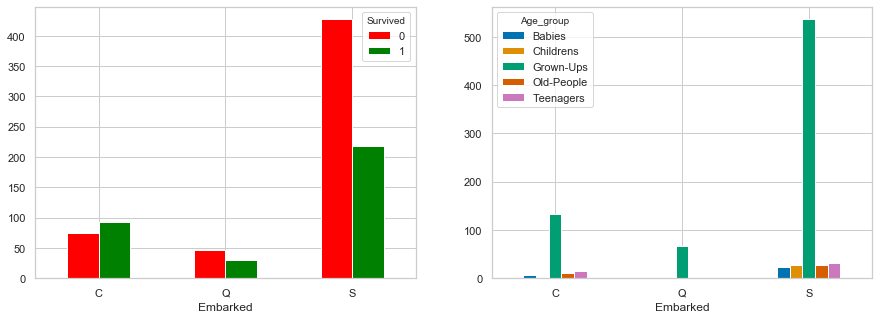

In [196]:
embarked_mapping = {0:"S", 1:"C",2:"Q"}
train_data.Embarked = train_data["Embarked"].map(embarked_mapping)

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
cmap = mpl.colors.ListedColormap(["red", "green"])

train_data.groupby("Embarked")["Survived"].value_counts().unstack().plot(kind="bar",colormap =cmap,ax=axs[0])
axs[0].tick_params(labelrotation=0)
pd.crosstab(train_data['Embarked'],train_data['Age_group']).plot.bar(ax=axs[1])
axs[1].tick_params(labelrotation=0)

The only embarked place which there is more people who survived is France.
Maybe it means that people from France were more strong? rich? not old?

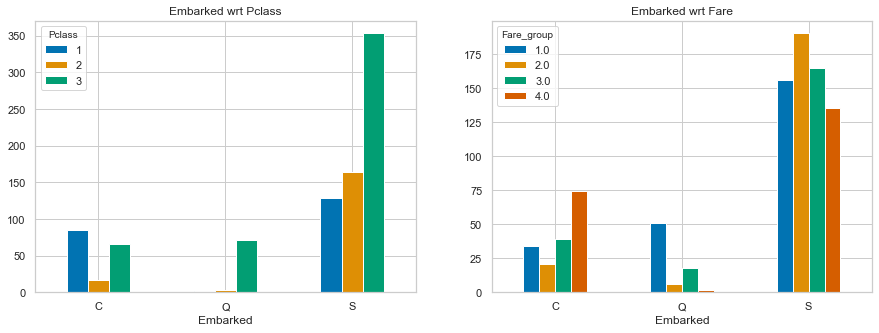

In [197]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

train_data.groupby("Embarked")["Pclass"].value_counts().unstack().plot(kind="bar",ax=axs[0], title="Embarked wrt Pclass")
axs[0].tick_params(labelrotation=0)

train_data.groupby("Embarked")["Fare_group"].value_counts().unstack().plot(kind="bar", ax=axs[1], title="Embarked wrt Fare")
axs[1].tick_params(labelrotation=0)

Yes, probably the prople from France was more rich than all the other embarked places.
Porportioanily they pay more than any one of the others groups.
But, let's check what is the correlation between the price of the tickets and the survival rate.

## 3.3 Fare

Text(0.5, 1, 'Correlation between Fare and Survival rate')

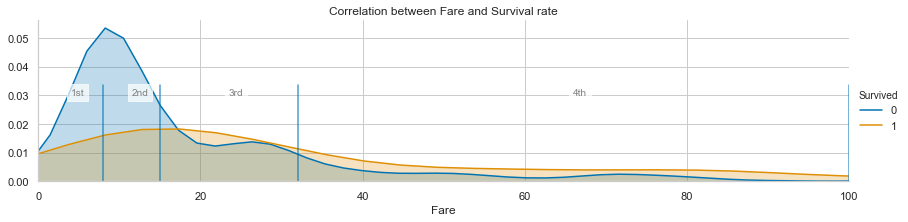

In [198]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Fare',shade= True)
facet.set(xlim=(0, train_data['Fare'].max()))
facet.add_legend()
plt.xlim(0,100)
style = dict(size=10, color='gray')
normalizer = 0
for k,v in {"1st":8,"2nd":15,"3rd":32,"4th":100}.items():
    plt.axvline(v, 0,0.60, alpha=0.7)
    plt.text(((v-normalizer)/2)+normalizer, 0.03, k, **style, bbox=dict(facecolor='white', alpha=0.7))
    normalizer=v
plt.title("Correlation between Fare and Survival rate")


As I expected, there is a correlation!


## 3.4 Age

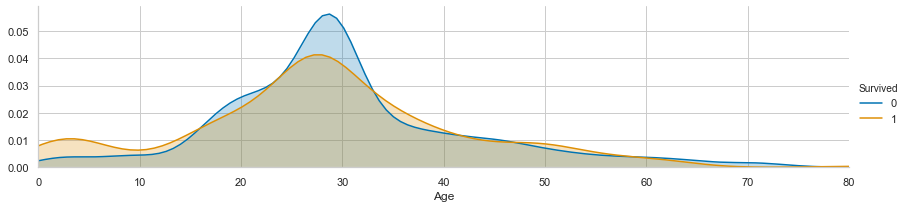

In [199]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()
 
plt.show()

Before we will start the model of prediction, i will transform all the paramters in the dataset to floats/int.

In [200]:
train_data.select_dtypes(include="object").columns

Index(['Name', 'Embarked', 'Age_group'], dtype='object')

In [201]:
embarked_mapping = {"S":0, "C":1,"Q":2}
train_data.Embarked = train_data["Embarked"].map(embarked_mapping)


In [202]:
train_data.drop("Age_group",axis=1, inplace=True)

In [203]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_data.Title.value_counts()
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2}
train_data.Title = train_data["Title"].map(title_mapping)

title_series = pd.to_numeric(train_data.Title, errors='coerce')
title_series.fillna(value=3, inplace=True)
train_data.Title = title_series

test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data.Title.value_counts()
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2}
test_data.Title = test_data["Title"].map(title_mapping)

title_series = pd.to_numeric(test_data.Title, errors='coerce')
title_series.fillna(value=3, inplace=True)
test_data.Title = title_series
test_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    int64  
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         417 non-null    float64
 8   Embarked     418 non-null    int64  
 9   Fare_group   417 non-null    float64
 10  Title        418 non-null    float64
dtypes: float64(4), int64(6), object(1)
memory usage: 36.0+ KB


In [204]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    int64  
 10  Fare_group   891 non-null    float64
 11  Title        891 non-null    float64
dtypes: float64(4), int64(7), object(1)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

## 4 Modeling <a class="anchor" id="4"></a>

To try to fit our machine learning model to this particular problem, i used the scikit-learn algorithm cheat-sheet.
We'll try some of the machine learning algorithms and observe which one is working best with our dataset.

In [205]:
url1 = "https://scikit-learn.org/stable/_static/ml_map.png"
html2 = f'<img src={url1} width="750" height="900" align="center"/>'
HTML(html2)

The only quantitive data we got in this dataset is the Age and the Fare columns and the other predictors are qualitative.
We tend to refer to problems with a quantitative response as regression problems, while those involving a qualitative response are often referred to as classification problems.
However, in this project i mainly want to learn how to use the algorithms, so i will try all kind of methods.



In [245]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

X = train_data.drop(["Survived", "Name","PassengerId"], axis=1)
y = train_data.Survived


#### 4.1 Logistic Regression

In [250]:
train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=42)
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
print(classification_report(test_y,predictions))
# confusion_mat = (confusion_matrix(test_y,predictions))
# (confusion_mat[0,0]+confusion_mat[1,1])/(confusion_mat.sum())

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       134
           1       0.73      0.74      0.74        89

    accuracy                           0.79       223
   macro avg       0.78      0.78      0.78       223
weighted avg       0.79      0.79      0.79       223



C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### Decision Tree 

In [253]:
tree_model = DecisionTreeRegressor(random_state=1)
tree_model.fit(train_X, train_y)

tree_predictions = tree_model.predict(val_X)
print(1-mean_absolute_error(val_y, tree_predictions))


0.7663178873941205


#### Linear Regression

In [254]:
linear_model = LinearRegression()
linear_model.fit(train_X, train_y)
cdf = pd.DataFrame(data=linear_model.coef_.T, index=X.columns, columns=["Coef"])
cdf.sort_values(by="Coef", ascending=False)

,Coef
Sex,0.388745
Title,0.123171
Embarked,0.029843
Fare_group,0.004236
Fare,0.000742
Age,-0.004254
Parch,-0.047290
SibSp,-0.057105
Pclass,-0.124749


**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [256]:
lm_predictions = linear_model.predict(val_X)
from sklearn import metrics
print(f"MAE: {metrics.mean_absolute_error(lm_predictions, val_y)}")
print(f"MSE: {metrics.mean_squared_error(lm_predictions, val_y)}")
print(f"MSE: {np.sqrt(metrics.mean_squared_error(lm_predictions, val_y))}")
print()
print(f"MAE score: {1-metrics.mean_absolute_error(lm_predictions, val_y)}")
print(f"MSE score: {1-metrics.mean_squared_error(lm_predictions, val_y)}")
print(f"MSE score: {1-np.sqrt(metrics.mean_squared_error(lm_predictions, val_y))}")

MAE: 0.28349057621825824
MSE: 0.13572897908710074
MSE: 0.36841414072630374

MAE score: 0.7165094237817418
MSE score: 0.8642710209128992
MSE score: 0.6315858592736963


This dataframe contain the impact every coeeficent have for the survival rate of the passenger